# LSPIV - Part 3: Post-processing
*GH Gerritsen*
___

This notebook discusses two post-processing steps for acquiring surface flow velocities at a specific cross-section. The post-processing steps are named *filtering* and *substitution*. Both processes are explained in following sections. For these steps several additional information is needed. Namely:

- local bathymetry,
- water level,
- parameters for the vertical progression of the surface flow velocities.

In the upcoming sections treat the following subjects: (1) the untreated results, (2) filtering of lower flow velocities, and (3) substitution of flow velocities of there is a lack of seeds.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import interpolate

In [2]:
dir_files = 'files'
bat = r'bathymetry.csv'

## Untreated results

For the post-processing only a small section of the original video is used -- i.e. the area of interest. This area lies 1 metre to the left and three metres to the right from the centre point of the bathymetry (provided in a .csv file). As the flow goes from left to right, only the *x-components* of the flow velocities are used to estimate the mean flow velocities.

The stream width is divided into different cross-sectional sections. For each section, the flow velocities are gathered and a mean value is determined.

First some basic characteristics are proveded. The location of the centre of the bathymetry in the imagery (`centre_x` and `centre_y`), the locations of the stream banks at the bathymetry (`y0` and `y1`), and the water level (`wl`) during the video.

In [3]:
# location of centre bathymetry in imagery. 
# Used to align the flow velocities with the bathymetry
centre_x, centre_y = [8.3471579 , 2.01868403]

# locations stream banks
y0, y1 = [-1.397, 3.785]

# water level (relative to lowest point bathymetry)
wl = 0.9

The bathymetry is found in the file `bathymetry.csv`. To be able to use this bathymetry, the points are interpolated using the `scipy.interpolate.interpolate` function.

In [4]:
# import the local bathymetry
bat = r'bathymetry.csv'
df_bat = pd.read_table(bat, sep=';', usecols=['Y', 'H'])

# interpolated function of the bathymetry
func_bat = interpolate.interp1d(df_bat['Y'], df_bat['H'], kind='quadratic')

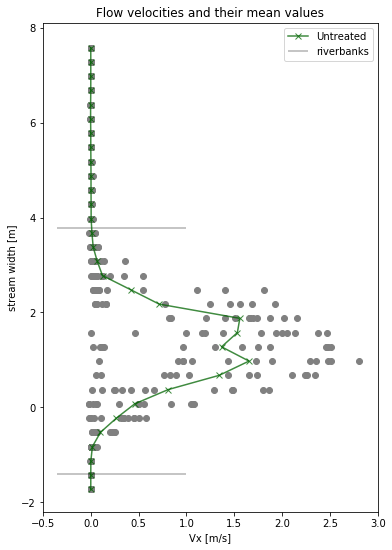

In [5]:
# extract the names of the text files
files = os.listdir(dir_files)

# create a dataframe in which all velocities in the area of interest are stored
vx_all = pd.DataFrame()

# create an array to save the mean velocities 
vx_mean_raw = []

for file in files:
    # import single file and append velocities in area of interest to dataframe
    df = pd.read_table(os.path.join(dir_files, file),
                       sep='\s+',
                       names=('X', 'Y', 'Vx', 'Vy', 's2n'))

    df = df[df['X']>(centre_x - 1)]
    df = df[df['X']<(centre_x + 3)]
    vx_all = vx_all.append(df)

# define the different y coordinates (stream width sections)
y_unique = np.sort(df.Y.unique())
    
# correct y coordinates relative to the bathymetry 'centre'
y_corrected = y_unique - centre_y

fig = plt.figure(figsize=(6,9))
# for each cross-sectional section, find the flow velocities and determine their mean value
for ii, yy in enumerate(y_unique):
    vx = df.Vx[df.Y == yy]
    vx_mean_raw.append(np.mean(vx[np.isfinite(vx)]))
    # show the individual velocities
    plt.scatter(vx, y_corrected[ii]*np.ones(len(vx)), color='grey', marker='o')


# show the the mean velocities of the untreated post-processing step
plt.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
plt.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
plt.title('Flow velocities and their mean values')
plt.xlabel('Vx [m/s]')
plt.ylabel('stream width [m]')
plt.xlim(-.5, 3)

plt.legend();

## Filtering

As the seeding density is not dense enough to have seeds at every grid cell, there are moments no surface flow velocities are estimated, resulting in a wide range of flow velocities. Therefore additional filtering is applied to remove lower flow velocity estimations.

This filtering is based on the distance of a measurement relative to the 95th percentile flow velocity in that cross-sectional section. If a value is further away than twice the standard deviation from the 95th percentile, this value is filtered out. Or in short, filtering is applied when the following statement is met:

$$V_{X} < V_{q95} - 2 \cdot \sigma_{V_{X}}$$

As this statement can result in over filtering, another statement (or threshold) has to be satisfied before filtering is applied at a cross-sectional section. The 95th percentile needs to be larger than 2.5 times the standard deviation:

$$V_{q95} > 2.5 \cdot \sigma_{V_{X}}$$

After excluding the flow velocities which are meeting the statements, new mean flow velocities estimations can be made.

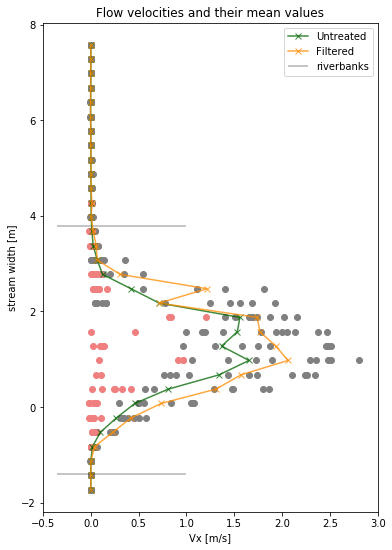

In [6]:
# array to store mean flow velocities
vx_mean_fil = []

fig = plt.figure(figsize=(6,9))

# for each cross section
# find the corresponding flow velocities and remove NaN values
for yy in y_unique:
    vxi = df.Vx[df.Y == yy]
    vxi = vxi[np.isfinite(vxi)]

    # if all values are NaN, create an array with length 1
    if len(vxi) == 0:
        vxi = [0]
    
    # determine the 95th quantile and standard deviation
    v_filter = np.quantile(vxi, 0.95)
    std = np.std(vxi)

    # filtering is applied if the 95th percentile > 2.5*std
    if 2.5*std/v_filter < 1:
        # filtering is applied on values further away than 2*std from the 95th percentile
        vxi_in = vxi[vxi > v_filter - 2*std]
        vxi_out = vxi[vxi < v_filter - 2*std]
        # add mean value based on filtered results
        vx_mean_fil.append(np.mean(vxi_in))

        # plot saved and removed points
        plt.plot(vxi_in, [yy-centre_y]*len(vxi_in), color='grey', linestyle='None', marker='o', zorder=1)
        plt.plot(vxi_out, [yy-centre_y]*len(vxi_out), color='lightcoral', linestyle='None', marker='o', zorder=1)

    # if filtering is not applied: determine mean over all values
    else:
        vx_mean_fil.append(np.mean(vxi))
        # plt saved points
        plt.plot(vxi, [yy-centre_y]*len(vxi), color='grey', linestyle='None', marker='o', zorder=1)

# show the individual velocities and the mean velocities of the untreated and filtered post-processing step
plt.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
plt.plot(vx_mean_fil, y_corrected, color='darkorange', marker='x', zorder=2, alpha=0.75, label='Filtered')
plt.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
plt.title('Flow velocities and their mean values')
plt.xlabel('Vx [m/s]')
plt.ylabel('stream width [m]')
plt.xlim(-.5, 3)

plt.legend();

## Substitution

As at certain cross-sectional sections no seeds are present, flow velocities are for sure underestimated at these locations. To still make an educated guess on the flow velocities at this locations, flow velocities at different stages of the flood wave are estimated and used to establish a relationship between the surface flow velocities and and water depth. This relationship is approximated using the Prandtl-von Kármán logarithmic law:

$$V_{x;sub}(h) = \frac{u_{\star}}{\kappa} \ln\left[\frac{h - d}{h_0}\right]$$

In this formula $V_{x;sub}(h)$ is the flow velocity at water depth $h$; $u_{\star}$ the shear velocity; $\kappa$ the von Kármán constant ($\approx0.41$); $h_0$ the roughness depth; and $d$ the zero-plane displacement. For the example video, $u_{\star}$, $h_0$, and $d$ are estimated to be $0.235$, $0.054$, and $0.15$, respectively.

The surface flow velocities is replaced if the surface flow velocity is half the substitution value and when the section is within the stream banks.

In [7]:
def vertical_flow(loc_wd, p, d=0.15):
    """
    Function returning the substitution value for a certain depth
    
    Input:
    ------
    loc_wd - local water depth
    p - array containing the shear velocity and roughness depth
    d - zero-plane displacements
    
    Output:
    -------
    u - surface flow velocity estimation    
    """
    us = p[0]
    h0 = p[1]
    return us/0.41 * np.log((loc_wd - d) / h0)

# vertical progression surface flow velocity parameters
param = [0.235, 0.054]

In [8]:
# create a copy of the filtered mean flow velocities
vx_mean_rep = vx_mean_fil.copy()

# determine waterdepths at different corrected y coordinates
# if there is water (wd>0) and if y is between -3 and 3 (no bushes)
# if mean*2 < value found using vertical profile
wd = wl - func_bat(y_corrected)
for nn, loc_wd in enumerate(wd):
    if loc_wd > 0.15:
        if (y_corrected[nn] > -3.5) and y_corrected[nn] < 3.5:
            # if 2*median value is below corrected value: correct value all percentiles
            if vx_mean_rep[nn] < 0.5*vertical_flow(loc_wd, param):
                    vx_mean_rep[nn] = vertical_flow(loc_wd, param)

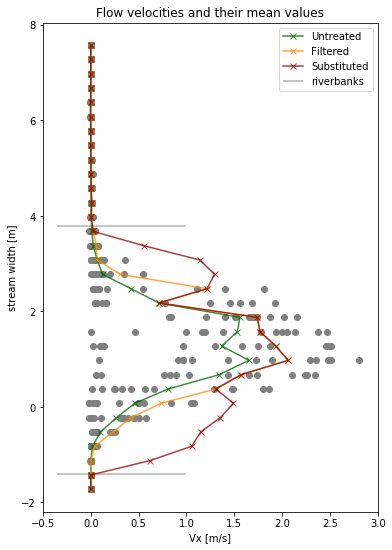

In [9]:
# show the individual velocities and the mean velocities of the different post-processing steps
fig = plt.figure(figsize=(6,9))
plt.scatter(df.Vx, df.Y-centre_y, color='grey', marker='o', zorder=1)
plt.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
plt.plot(vx_mean_fil, y_corrected, color='darkorange', marker='x', zorder=2, alpha=0.75, label='Filtered')
plt.plot(vx_mean_rep, y_corrected, color='darkred', marker='x', zorder=2, alpha=0.75, label='Substituted')
plt.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
plt.title('Flow velocities and their mean values')
plt.xlabel('Vx [m/s]')
plt.ylabel('stream width [m]')
plt.xlim(-.5, 3)

plt.legend();

## Discharge estimation
Discharges are estimated using the velocity-area method, using the following formula:

$$Q = \sum_{n=1}^{N} v_n \cdot d_n \cdot b_n$$

where $v_n$, $d_n$, and $b_n$ are the section's depth-average flow velocity, depth and width, respectively. 

For the depth-average flow velocity, the surface flow velocity is multiplied with an empirical determined coefficient $\alpha$. This coefficient usually lies between $0.72$ and $0.95$. For the example video the coefficient is estimated to be $0.85$.

In [10]:
# depth-average coefficient
alpha = 0.85

# width cross-sectional sections
step = y_corrected[1]-y_corrected[0]

# discharge estimation
Q = sum(vx_mean_rep * wd  * alpha * step)

print("Mean discharge is estimated at {} m³/s".format(round(Q, 2)))

Mean discharge is estimated at 3.92 m³/s


___